<a href="https://colab.research.google.com/github/rosesardina/ECE61000-EnergyConversion/blob/main/reference_frame_observations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook created by:<br>
Dionysios Aliprantis  |  Professor of
Electrical and Computer Engineering, Purdue University<br>
465 Northwestern Ave., West Lafayette, Indiana 47907-2035<br>
765.494.4434  |  dionysis@purdue.edu<br>
https://engineering.purdue.edu/~dionysis/<br>

Revision: August 26, 2021

Note: This notebook is intended for use by students of ECE 61000 Energy Conversion at Purdue University. The material is subject to change without notice. Unless otherwise noted, figures are obtained from the course textbook: P. Krause, O. Wasynczuk, S. Sudhoff, and S. Pekarek, *Analysis of Electric Machinery and Drive Systems*, Third edition, 2013, Wiley-IEEE Press.


---

# Simulation of three-phase *RL* circuit in the arbitrary reference frame

*Objectives:*

* Simulate a three-phase *RL* circuit in $qd$ variables in an arbitrary frame of reference.
* Observe the transient response of a three-phase *RL* circuit from different reference frames.

*Prerequisites:*

* General interest in power systems engineering ;)
* Complete the previous  notebook: https://colab.research.google.com/drive/1nZl-OGFO9nYDvQD4GdPTbbdh5ZjiNhwS
* Watch the lecture videos of the Reference Frame Theory section.

<br>


---




## Symmetric load connected to symmetric source

Consider a Y-connected, symmetric, series *RL* circuit with the following parameters (from page 107, Section 3.9 in the textbook):
* resistance $r_s = 0.216~\Omega$
* self inductance $L_s = 1.09/\omega_e$ H
* mutual inductance $M = 0$ H


The voltage   equations of the load are:
\begin{equation}
\mathbf{v}_{abcs} = r_s \mathbf{i}_{abcs} + L_s p\mathbf{i}_{abcs}
\end{equation}

<br>

The circuit is connected to a three-phase, Y-connected, balanced source with:
* rms value $E = 10/\sqrt{2}$ V
* angular frequency $\omega_e = 377$ rad/s (i.e., $f = 60$ Hz)
* phase $\theta_{e0} = 0$ rad

so that the $abc$ source voltages are
\begin{align*}
e_{a}(t) &= \sqrt{2} E \cos(\omega_e t + \theta_{e0}) \\
e_b(t) &= \sqrt{2} E \cos(\omega_e t + \theta_{e0} - 2\pi/3)\\
e_c(t) &= \sqrt{2} E \cos(\omega_e t + \theta_{e0} + 2\pi/3) \,.
\end{align*}
The source is connected directly across the load at $t=0$.
Due to source and load symmetry, we have learned that this implies:
$$
\mathbf{v}_{abcs} = \mathbf{e}_{abc} \,.
$$
<br>

In the textbook (Section 3.9), the approach is to obtain an analytical form of the current waveforms in $abc$ variables, and then to transform this solution to other reference frames.
Here, we will attempt to simulate the energization of the circuit directly in the various reference frames described in this section.
The equations that govern the circuit dynamics are:
\begin{align}
v_{qs} &= r_s i_{qs} + \omega L_s i_{ds} + L_s p i_{qs} \\
v_{ds} &= r_s i_{ds} - \omega L_s i_{qs} + L_s p i_{ds}
\end{align}
Here, $\omega = d\theta/dt$ can be an arbitrary function of time.
Note that the reference frame angle $\theta$ must be continuous for the derivative to exist.

Therefore, we obtain the following system of differential equations:
\begin{align}
 p i_{qs}  &= -\frac{r_s}{L_s} i_{qs} - \omega i_{ds} + \frac{\sqrt{2} E}{L_s} \cos(\omega_e t - \theta) \\
 p i_{ds} &= -\frac{r_s}{L_s} i_{ds} + \omega i_{qs} - \frac{\sqrt{2} E}{L_s} \sin(\omega_e t - \theta) \\
 p \theta &= \omega
\end{align}
The reference frame speed $\omega$ is a time-varying input in these equations.
Once this is given, we (i.e., the computer) should be able to integrate the differential equations starting from  initial condition $i_{qs}(0) = i_{ds}(0) = 0$ and $\theta(0) = 0$.


### Import Python libraries

In [ ]:
# Import libraries we need to calculate
import numpy as np
import scipy.integrate as spint
from math import pi, sqrt, cos, sin

# Import plotting library and set defaults
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
#sns.set_context("talk")
#plt.style.use("dark_background")

### Define circuit parameters

In [ ]:
# define circuit and source parameters -- from Section 3.9
f          =  60 # frequency (Hz)
w_e        =  2*pi*f # frequency (rad/s)
r_s        =  0.216 # resistance (ohm)
L_s        =  1.09/w_e # self-inductance (henries, H)
M          =  0 # mutual inductance (H)
E          =  10/sqrt(2) # rms voltage (V)
theta_e0   =  0 # voltage phase angle (rad)

# calculate useful constants
E_pk       = sqrt(2)*E # peak voltage
tau        = (L_s - M)/r_s # time constant of circuit
phi        = np.arctan2(w_e*(L_s-M),r_s) # power factor angle (rad)
Z_s        = r_s + 1j*w_e*(L_s-M) # per-phase impedance (R + jX, ohm)
I_pk       = E_pk/np.abs(Z_s) # steady-state current peak (A)
L          = np.array([[L_s, M, M],[M, L_s, M],[M, M, L_s]]) # inductance matrix
Linv       = np.linalg.inv(L) # inverse of L
P_ss       = 3/2*I_pk*E_pk*cos(phi) # steady state real power (W)
Q_ss       = 3/2*I_pk*E_pk*sin(phi) # steady state reactive power (VAr)
S_ss       = P_ss + 1j*Q_ss # complex power (MW + jMVAr)

print('Circuit parameters:')
print('time constant              tau = {:.2f} ms'.format(tau*1e3))
print('power factor angle         phi = {:.2f} deg'.format(phi/pi*180))
print('power factor                pf = {:.2f} lagging'.format(cos(phi)))
print('impedance                  Z_s = {:.3f} Ohm'.format(Z_s))
print('phase current              I_s = {:.2f} A, rms'.format(I_pk/sqrt(2)))
print('real power                   P = {:.2f} W'.format(P_ss))
print('reactive power               Q = {:.2f} VAr'.format(Q_ss))

Circuit parameters:
time constant              tau = 13.39 ms
power factor angle         phi = 78.79 deg
power factor                pf = 0.19 lagging
impedance                  Z_s = 0.216+1.090j Ohm
phase current              I_s = 6.36 A, rms
real power                   P = 26.24 W
reactive power               Q = 132.41 VAr


### Solve the circuit

Our problem is of the form:
$$
p\mathbf{y} = \mathbf{f}(\mathbf{y}, t) ~~\text{with}~~\mathbf{y}(0) = \mathbf{0} \,.
$$

We will use the solve_ivp function from scipy.integrate to obtain a numerical solution to our initial value problem.
For more information about this, please refer to the online documentation: https://docs.scipy.org/doc/scipy/reference/integrate.html


The solver successfully reached the end of the integration interval.




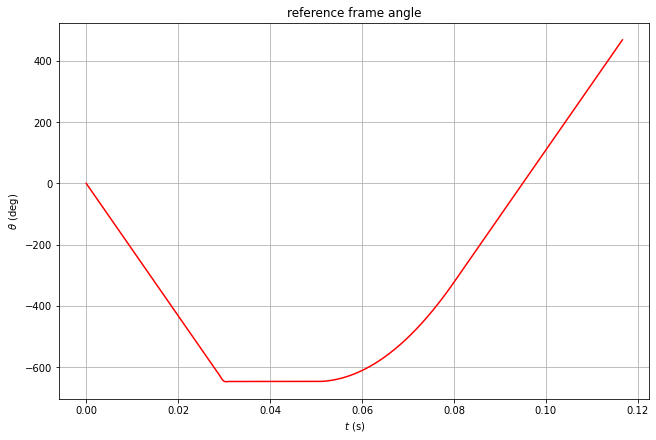

In [ ]:
# voltage source function definition
def e_qd(t,theta):
  theta_e = w_e*t + theta_e0
  e_q =  E_pk*np.cos(theta_e - theta) # using the NumPy cos allows `t' to be an array
  e_d = -E_pk*np.sin(theta_e - theta)
  return np.array([e_q,e_d])

# Reference frame speed
RF_case = 3  # 1: stationary, 2: synchronous, 3: other waveform
def w(t):
  if RF_case == 1:
    return 0
  elif RF_case == 2:
    return w_e
  elif RF_case == 3:
    # time constants determined by inspection of the textbook plot
    t1 = 0.03
    t2 = 0.05
    t3 = 0.08
    if t < t1:
      return -w_e
    elif t < t2:
      return 0
    elif t < t3:
      return (t - t2)/(t3 - t2)*w_e
    else:
      return w_e

# derivative function definition
def fun(t, y):
  f = np.zeros((3,1))
  u = e_qd(t, y[2])/(L_s - M)
  w_RF = w(t)

  f[0] = -y[0]/tau - w_RF*y[1] + u[0]
  f[1] = -y[1]/tau + w_RF*y[0] + u[1]
  f[2] = w_RF
  return f

# solve ODE
y_0        = np.zeros(3) # initial condition
N_cycles   = 7
t_span     = (0,N_cycles/f) # time span
N_pts      = 1000
t_eval     = np.linspace(t_span[0],t_span[-1],N_pts)
sol        = spint.solve_ivp(fun, t_span, y_0, method='RK45', t_eval=t_eval,\
                             vectorized=True)
print(sol.message)

t = sol.t
i_qds = sol.y[0:2,:]
theta = sol.y[2,:]

# plot this as a sanity check
print('\n')
plt.figure(figsize=(9,6), constrained_layout=True)
plt.plot(t,theta/pi*180,'r')
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\theta$ (deg)')
plt.title('reference frame angle')
plt.grid()

# post-processing
v_qds = e_qd(t,theta)
pwr = 1.5*np.sum(np.multiply(v_qds,i_qds),axis=0)
w_vec = np.zeros(t.shape)
for k in range(t.size):
  w_vec[k] = w(t[k])

Now, let's plot the solution, i.e., the $qd$ current waveforms. These waveforms should match those provided in the textbook (Figs. 3.9-1 through 3.9-3).
Change the parameter `RF_case' in line 9 of the code above to obtain the three plots.

We will also plot the total 3-phase power consumption of the circuit as a function of time:
$$
P(t) = \frac{3}{2} \mathbf{v}_{qd0s}^\top(t) \,\mathbf{i}_{qd0s}(t) \,.
$$

In [ ]:
print('max power draw = {:.2f} W'.format((P_ss + np.abs(S_ss))))

max power draw = 161.23 W


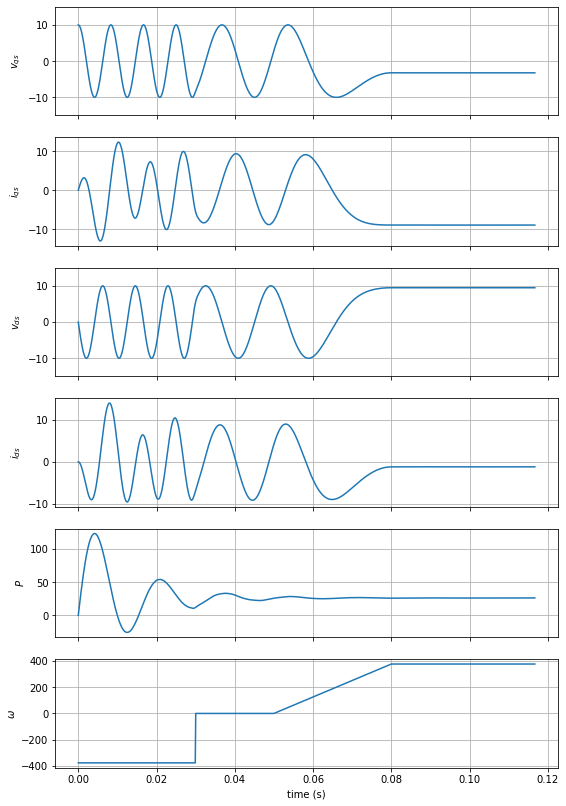

In [ ]:
# Plot currents and power
plt.figure(figsize=(9,14), constrained_layout=False)

ax = plt.subplot(6,1,1)
plt.plot(t,v_qds[0,:])
plt.ylim([-15,15])
plt.ylabel(r'$v_{qs}$')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(6,1,2)
plt.plot(t,i_qds[0,:])
plt.ylabel(r'$i_{qs}$')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(6,1,3)
plt.plot(t,v_qds[1,:])
plt.ylabel(r'$v_{ds}$')
plt.ylim([-15,15])
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(6,1,4)
plt.plot(t,i_qds[1,:])
plt.ylabel(r'$i_{ds}$')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(6,1,5)
plt.plot(t,pwr)
plt.ylabel(r'$P$')
ax.set_xticklabels('')
plt.grid()

ax = plt.subplot(6,1,6)
plt.plot(t,w_vec)
plt.ylabel(r'$\omega$')
plt.xlabel('time (s)')
plt.grid();

###Exercises:

1. Suppose that at time $t_1 = 0.05$ s,   a three-phase short circuit occurs that lasts until $t_2 = 0.1$ s. During this time period, the voltage across the load can be assumed to be zero. Afterwards, the fault is cleared.  Hence,
$$
\mathbf{v}_{abcs}(t) = \begin{cases}
\mathbf{e}_{abc}(t) & \text{for } 0 \leq t < t_1 \\
\mathbf{0} & \text{for } t_1 \leq t < t_2 \\
\mathbf{e}_{abc}(t) & \text{for } t \geq t_2
\end{cases}
$$
Simulate this phenomenon. Use the reference frame of your preference.

2. Suppose that at time $t = 0.05$ s, the reference frame angle must undergo a step change by $\delta \theta = 30^\circ$. How would you implement this?

3. Suppose that the voltage source is not perfectly balanced.  (See textbook problems 3.17 and 3.18.) The load is Y-connected without a neutral wire. In this case, we may not have a nice analytical expression for the transformed voltages (unless we solve these homework problems). Define a Python function that transforms the $abc$ voltages to the arbitrary reference frame. Define on your own some mild imbalance conditions, and conduct a time-domain simulation. Use the reference frame of your preference.



---


## Conclusion

We simulated the energization of a symmetric three-phase *RL* circuit in various reference frames.

Our equations allowed for a time-varying reference frame speed.
Although this may seem a somewhat bizarre and unnecessary complication (why not just keep it constant?), it is actually what we must do to simulate synchronous machines, where it is advantageous to conduct the simulations on the rotor reference frame (Park's transformation), which does not maintain a constant speed during transients.




